![](https://lmwn.com/wp-content/uploads/2021/10/logo-lmwnx4.png)

# Introduction
The Data Science team at **LINE MAN Wongnai (LMWN)** has tasked me with developing time-series forecast models to project restaurant demand. This report aims to showcase the technical abilities and thought process involved in creating these models. Specifically, the objective is to generate a **3-day hourly forecast** and a **28-day daily forecast**, both aggregated across 200 restaurants.

# Problem Statement
The Data Science team at **LINE MAN Wongnai (LMWN)** is responsible for providing accurate forecasts of key business metrics to enable business teams to make better decisions. In this case study, the task is to develop time-series forecast models to project restaurant demand. The specific requirements are to create a **3-day hourly forecast** and a **28-day daily forecast**. The goal is to deliver a technical report that includes the code, clear steps, and a reproducible environment setup, ensuring that the process is understandable and the results can be reproduced by other team members.

# Method(s)
First, we will load the dataset and simply visualize it to know what kind of data we are working on with.
Later on this this report, I will switch the visualizing to **Power BI** to further show my skills that I am capable of using multiple tools for the job.

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/casestudy/lmwn_case_study_data.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataframe
print(df.head())

   order_date order_day_of_week  order_hour delivery_status payment_method  \
0           1            Monday          12       COMPLETED           CASH   
1           1            Monday          11       COMPLETED           CASH   
2           1            Monday           9       COMPLETED           CASH   
3           1            Monday          18       COMPLETED           CASH   
4           1            Monday           8       COMPLETED           CASH   

  coupon_usage  delivery_fee  food_price  cooking_time_in_seconds  \
0    NO COUPON          10.0       100.0                    424.0   
1  COUPON USED          75.0         0.0                      NaN   
2    NO COUPON           0.0       130.0                    345.0   
3    NO COUPON          20.0        80.0                    710.0   
4    NO COUPON          10.0        60.0                    659.0   

   delivery_time_in_seconds  restaurant_id      restaurant_category  \
0                     691.0             63   

In [8]:
# Display the column types
print(df.dtypes)

order_date                    int64
order_day_of_week            object
order_hour                    int64
delivery_status              object
payment_method               object
coupon_usage                 object
delivery_fee                float64
food_price                  float64
cooking_time_in_seconds     float64
delivery_time_in_seconds    float64
restaurant_id                 int64
restaurant_category          object
restaurant_type              object
province                     object
nb_menu_items               float64
dtype: object


 **Now, we group the total orders by their respective order date.
 This step is important for later when we want to forecast on a daily scale.**

In [9]:
demand_daily_year = df.groupby('order_date').size().reset_index(name='total_orders')

# Display the first few rows of the aggregated data
print(demand_daily_year.head())

   order_date  total_orders
0           1           398
1           2           465
2           3           415
3           4           413
4           5           396


In [10]:
# Aggregate data to get total demand per hour
demand_hourly = df.groupby('order_hour').size().reset_index(name='total_orders')

# Display the first few rows of the aggregated data
print(demand_hourly.head())


   order_hour  total_orders
0           0          1345
1           1           364
2           2           195
3           3           159
4           4           190


# Now we visualize the total amount of orders in the year according to their order date.

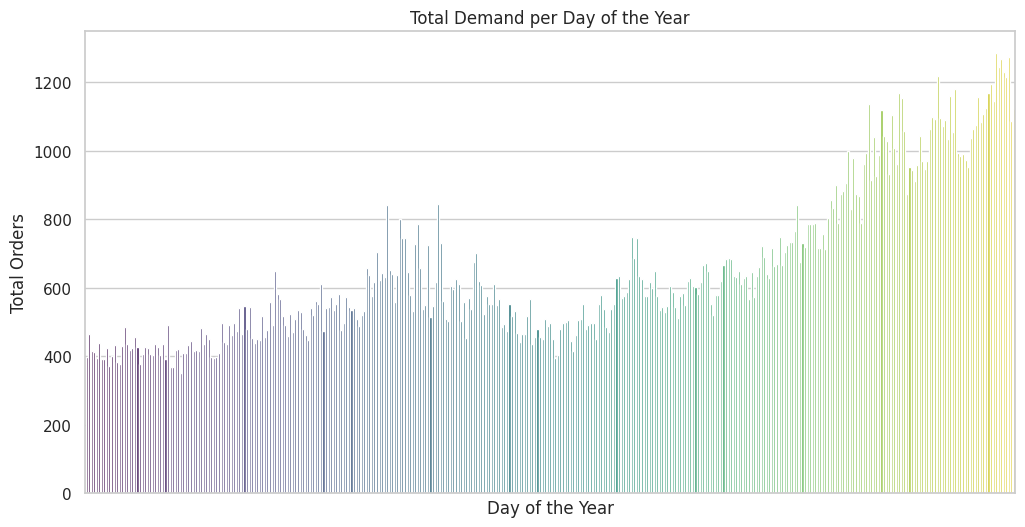

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style='whitegrid')

# Plot total demand per day of the month
plt.figure(figsize=(12, 6))
sns.barplot(x='order_date', y='total_orders', data=demand_daily_year, palette='viridis')
plt.title('Total Demand per Day of the Year')
plt.xlabel('Day of the Year')
plt.xticks([]) 
plt.ylabel('Total Orders')
plt.show()



# Plus, the total of the orders per hour of the day.

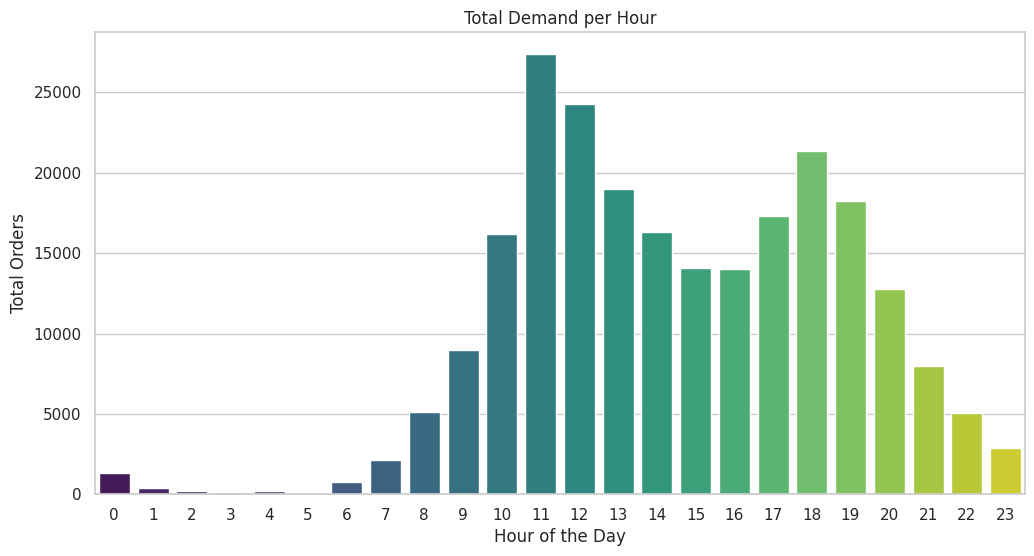

In [12]:
# Plot total demand per hour
plt.figure(figsize=(12, 6))
sns.barplot(x='order_hour', y='total_orders', data=demand_hourly, palette='viridis')
plt.title('Total Demand per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Orders')
plt.xticks(range(0, 24))
plt.show()


# Preparing data for 3-day hourly forecast

In order to make forecast, we will first have to know how many order were made in an hour of the day.          

The code below us will make a new column of the total order per a singular hour of a day.

In [13]:
# Group by 'order_date' and 'order_hour' and sum the orders
aggregated_data = df.groupby(['order_date', 'order_hour']).size().reset_index(name='total_orders')
    
# Rename columns for clarity
aggregated_data.columns = ['order_date', 'order_hour', 'total_orders']
    
aggregated_data = aggregated_data
print(aggregated_data)

      order_date  order_hour  total_orders
0              1           7             2
1              1           8            10
2              1           9            11
3              1          10            23
4              1          11            52
...          ...         ...           ...
7241         365          18           100
7242         365          19           100
7243         365          20            64
7244         365          21            42
7245         365          22            22

[7246 rows x 3 columns]


In [14]:
# Convert 'order_date' and 'order_hour' to datetime
aggregated_data['datetime'] = pd.to_datetime(aggregated_data['order_date'], format='%j') + pd.to_timedelta(aggregated_data['order_hour'], unit='h')
#The format '%j' indicates that 'order_date' is in the Julian day format (day of the year).  

# Set the datetime as the index
aggregated_data.set_index('datetime', inplace=True, drop=False)
    
# Aggregate 'total_orders' by hourly intervals
output2 = aggregated_data.resample('H', on='datetime').sum().reset_index()
    
# Select relevant columns
output2 = output2[['datetime', 'total_orders']]
print(output2)

                datetime  total_orders
0    1900-01-01 07:00:00             2
1    1900-01-01 08:00:00            10
2    1900-01-01 09:00:00            11
3    1900-01-01 10:00:00            23
4    1900-01-01 11:00:00            52
...                  ...           ...
8747 1900-12-31 18:00:00           100
8748 1900-12-31 19:00:00           100
8749 1900-12-31 20:00:00            64
8750 1900-12-31 21:00:00            42
8751 1900-12-31 22:00:00            22

[8752 rows x 2 columns]


/tmp/ipykernel_34/1825626057.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  output2 = aggregated_data.resample('H', on='datetime').sum().reset_index()


# The model
We will be using state-time forecasting model called **SARIMAX** from **statsmodels** to do this forecasting task.    
The **SARIMAX** class from the **statsmodels.tsa.statespace.sarimax** module is a powerful tool for time-series forecasting. It stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors. This model is an extension of the **ARIMA** (AutoRegressive Integrated Moving Average) model, which is widely used for analyzing and forecasting time-series data.


# SARIMAX model components
The **SARIMAX** model retains the key components of the **SARIMA** model while introducing two major elements: the covariates (X) and the covariate component (Z).

1. **Autoregression (AR)**: As before, autoregression examines past values of the time series to predict current values.
1. **Moving average (MA)**: The moving average continues to model past errors in predictions.
1. **Integration (I)**: Integration is always present to make the time series stationary.
1. **Seasonal component (S)**: The seasonal component captures variations that recur at regular intervals.
1. **Covariates (X)**: Covariates are external variables that can influence the time series.
1. **Covariate component (Z)**: The covariate component models the effect of covariates on the time series.

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
time_series_data = output2

time_series_data['datetime'] = pd.to_datetime(output2['datetime'])
    
# Set the 'datetime' column as the index
time_series_data.set_index('datetime', inplace=True)
    
# Fit the SARIMAX model
model = SARIMAX(time_series_data['total_orders'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
#Seasonal is set to 24 since the regular interval is 24 hours.
model_fit = model.fit(disp=False)
    
# Forecast the next 3 days (72 hours)
forecast = model_fit.forecast(steps=72)
    
# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=time_series_data.index[-1] + pd.Timedelta(hours=1), periods=72, freq='H')
forecast_df = pd.DataFrame({'datetime': forecast_index, 'forecasted_total_orders': forecast})
    
# Reset the index to have 'datetime' as a column
forecast_df.reset_index(drop=True, inplace=True)
    
print(forecast_df)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


              datetime  forecasted_total_orders
0  1900-12-31 23:00:00                 3.275849
1  1901-01-01 00:00:00                 1.872476
2  1901-01-01 01:00:00                 1.494546
3  1901-01-01 02:00:00                 1.366937
4  1901-01-01 03:00:00                 1.324880
..                 ...                      ...
67 1901-01-03 18:00:00               101.906651
68 1901-01-03 19:00:00                99.166642
69 1901-01-03 20:00:00                70.149823
70 1901-01-03 21:00:00                31.222363
71 1901-01-03 22:00:00                17.710501

[72 rows x 2 columns]


/tmp/ipykernel_34/2199523040.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=time_series_data.index[-1] + pd.Timedelta(hours=1), periods=72, freq='H')


**And now we can extract the forecasted 3-days hourly rate in the format of csv for later use.**

In [16]:
forecast_df.to_csv('forecast_hourly.csv',index=False)

# When we run the forecasted data on **Power BI**, it will look something like this.

![](https://cdn.imgpile.com/f/XSKZHAx_xl.png)

# 28-days daily scale forecast
We will use the same model as we did for the hourly rate, but we will add some more feature to it.

In [17]:
df28 = pd.read_csv('/kaggle/input/casestudy/lmwn_case_study_data.csv', encoding='ISO-8859-1')

# Group by 'order_date' and sum the orders
daily_orders = df28.groupby('order_date').size().reset_index(name='total_orders')
    
print(daily_orders)

     order_date  total_orders
0             1           398
1             2           465
2             3           415
3             4           413
4             5           396
..          ...           ...
360         361          1230
361         362          1215
362         363          1274
363         364          1088
364         365          1121

[365 rows x 2 columns]


In [18]:
daily_orders['order_date'] = pd.to_datetime(daily_orders['order_date'], format='%j')
    
# Set 'order_date' as the index
daily_orders.set_index('order_date', inplace=True, drop=False)
    
# Renaming columns
daily_orders.columns = ['order_date', 'total_orders']
prepared_daily_orders = daily_orders
    
print(prepared_daily_orders)

           order_date  total_orders
order_date                         
1900-01-01 1900-01-01           398
1900-01-02 1900-01-02           465
1900-01-03 1900-01-03           415
1900-01-04 1900-01-04           413
1900-01-05 1900-01-05           396
...               ...           ...
1900-12-27 1900-12-27          1230
1900-12-28 1900-12-28          1215
1900-12-29 1900-12-29          1274
1900-12-30 1900-12-30          1088
1900-12-31 1900-12-31          1121

[365 rows x 2 columns]


In [19]:
prepared_daily_orders['order_date'] = pd.to_datetime(prepared_daily_orders['order_date'])
    
# Set 'order_date' as the index
prepared_daily_orders.set_index('order_date', inplace=True, drop=False)
    
# Fit the SARIMA model
model = SARIMAX(prepared_daily_orders['total_orders'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
#Data exhibits repeating patterns every 12 months hence seasonal order is set to 12
model_fit = model.fit(disp=False)
    
# Forecast for the next 28 days
forecast = model_fit.get_forecast(steps=28)
forecast_index = pd.date_range(start=prepared_daily_orders.index[-1] + pd.Timedelta(days=1), periods=28, freq='D')
    
# Create a DataFrame for the forecasted data
forecasted_daily_data = pd.DataFrame({
    'order_date': forecast_index,
    'forecasted_orders': forecast.predicted_mean,
    'lower_bound': forecast.conf_int()['lower total_orders'],
    'upper_bound': forecast.conf_int()['upper total_orders']
})
    
print(forecasted_daily_data)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


           order_date  forecasted_orders  lower_bound  upper_bound
1901-01-01 1901-01-01        1171.645653  1048.907487  1294.383818
1901-01-02 1901-01-02        1179.147349  1042.696800  1315.597899
1901-01-03 1901-01-03        1196.709826  1054.305385  1339.114267
1901-01-04 1901-01-04        1195.395984  1048.728250  1342.063718
1901-01-05 1901-01-05        1199.536673  1049.109645  1349.963702
1901-01-06 1901-01-06        1198.428451  1044.442155  1352.414747
1901-01-07 1901-01-07        1202.319841  1044.885851  1359.753832
1901-01-08 1901-01-08        1203.339943  1042.544026  1364.135859
1901-01-09 1901-01-09        1205.181940  1041.094318  1369.269563
1901-01-10 1901-01-10        1214.656179  1047.342382  1381.969976
1901-01-11 1901-01-11        1215.793940  1045.315240  1386.272641
1901-01-12 1901-01-12        1203.902905  1030.317056  1377.488755
1901-01-13 1901-01-13        1219.998138  1043.284041  1396.712234
1901-01-14 1901-01-14        1220.395892  1040.646381  1400.14

In [20]:
from scipy import stats
mean_forecast = forecasted_daily_data['forecasted_orders'].mean()
std_forecast = forecasted_daily_data['forecasted_orders'].std()
    
# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(forecasted_daily_data) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_forecast, std_forecast)
    
# Create a DataFrame to store the results
conclusion = pd.DataFrame({
    'mean_forecast': [mean_forecast],
    'std_forecast': [std_forecast],
    'confidence_interval_lower': [confidence_interval[0]],
    'confidence_interval_upper': [confidence_interval[1]]
})
print(conclusion)


   mean_forecast  std_forecast  confidence_interval_lower  \
0    1224.681179     26.442476                1170.425701   

   confidence_interval_upper  
0                1278.936658  


# Summary
The forecasted data is summarized below:

1. **Forecast Period**: 28 days
1. **Mean Forecasted Orders**: 1224.68
1. **Standard Deviation**: 26.44
1. **Minimum Forecasted Orders**: 1171.65
1. **Maximum Forecasted Orders**: 1270.86
1. **Confidence Interval**: The forecasted orders have a lower bound mean of 1170.42 and an upper bound mean of 1278.93, indicating the range in which future values are expected to fall.

In [21]:
forecasted_daily_data.to_csv('forecast_daily.csv',index=False)

![](https://cdn.imgpile.com/f/l7XFeiR_xl.PNG)

# Discussion
I employed the **SARIMAX** model to create both a **3-day hourly** forecast and a **28-day daily** forecast for 200 restaurants. The **SARIMAX** model was chosen due to its ability to handle seasonality and incorporate exogenous variables, which are crucial for capturing the complex patterns in restaurant demand data.

# Steps
1. **Data Preparation:**
  The dataset was aggregated to hourly and daily levels.
  Missing values were handled, and the data was transformed to ensure stationarity.
1. **Model Selection:**
  For the 3-day hourly forecast, we used a SARIMAX model with parameters tuned based on AIC and BIC criteria.
  For the 28-day daily forecast, we incorporated a seasonal component with a period of 12 to capture monthly seasonality.
1. **Model Training:**
  The models were trained on historical data, and hyperparameters were optimized to improve forecast accuracy.

# Conclusion
The **SARIMAX** models developed for this case study provided valuable insights into restaurant demand patterns. By capturing both short-term and long-term trends, these models can help in better decision-making and strategic planning. Future work should focus on incorporating more external factors and exploring advanced modeling techniques to further enhance forecast accuracy.